In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import glob

from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

import sklearn 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay

import HigherTierModel

In [2]:
###########################################################
# Define file
###########################################################

# Get training file
trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/without2DPFPs/ccnutree_*.npz')
print(trainFileNames)

['/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/without2DPFPs/ccnutree_1.npz']


In [3]:
###########################################################
# Hyperparameters
###########################################################

nEpochs = 10
batchSize = 64
learningRate = 1e-3

In [4]:
###########################################################
# Get data from file
###########################################################

# Variables
variables_train = np.empty((0, 12))
variables_test = np.empty((0, 12))

# Truth
y_train = np.empty((0, 1))
y_test = np.empty((0, 1))

for trainFileName in trainFileNames :
    print('Reading file: ', str(trainFileName),', This may take a while...')
    
    data = np.load(trainFileName)

    # Variables
    variables_train = np.concatenate((variables_train, data['variables_train']), axis=0)
    variables_test = np.concatenate((variables_test, data['variables_test']), axis=0)
    # Truth
    y_train = np.concatenate((y_train, data['y_train']), axis=0)
    y_test = np.concatenate((y_test, data['y_test']), axis=0)

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)

nVariables = variables_train.shape[1]
ntrain = variables_train.shape[0]
ntest  = variables_test.shape[0]

Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/without2DPFPs/ccnutree_1.npz , This may take a while...
variables_train.shape: (818064, 12)
variables_test.shape: (90896, 12)
y_train.shape: (818064, 1)
y_test.shape: (90896, 1)


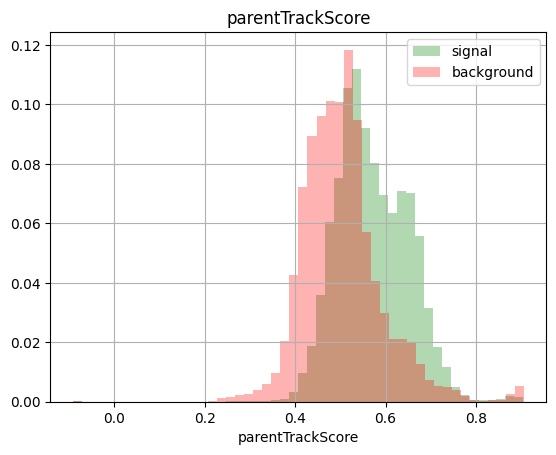

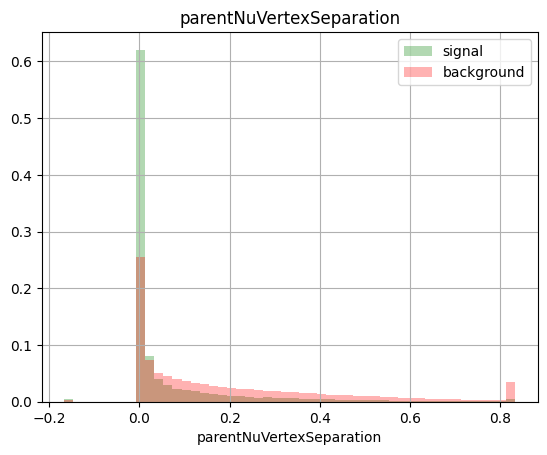

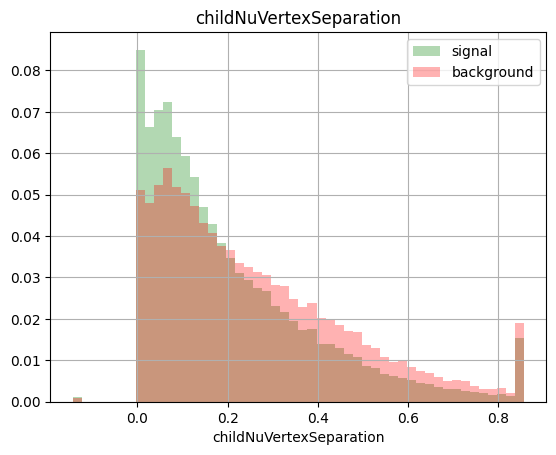

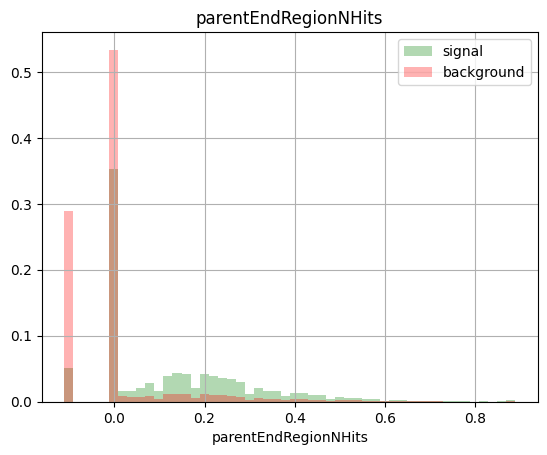

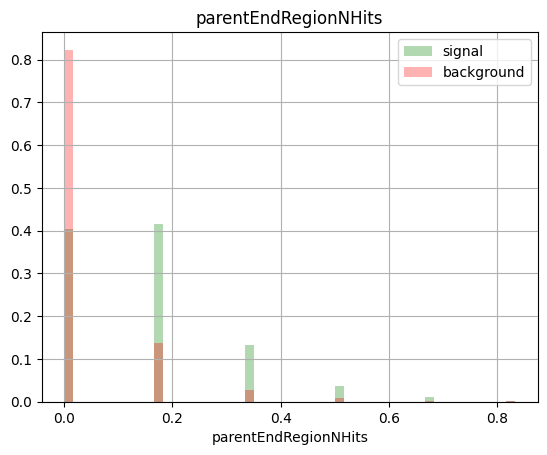

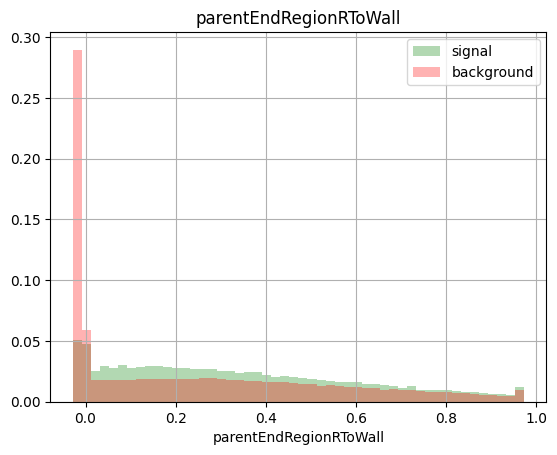

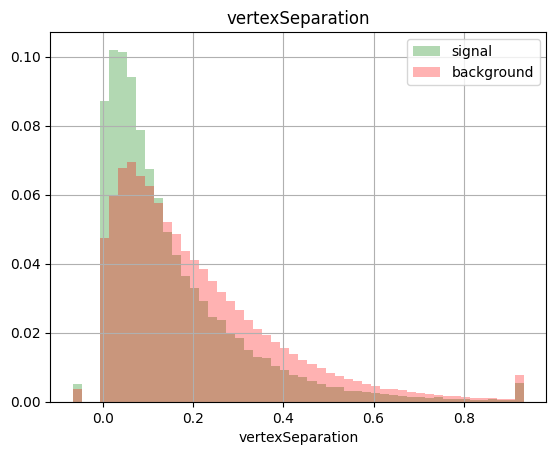

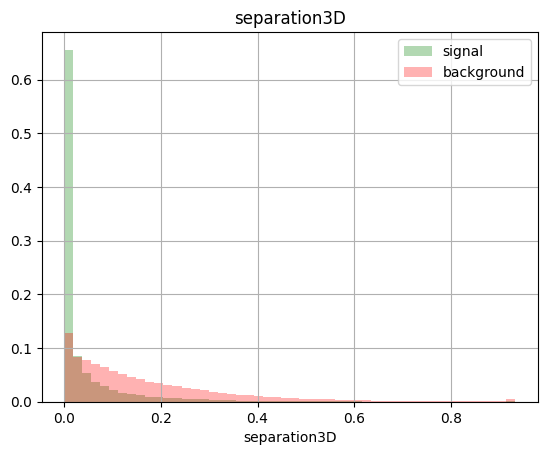

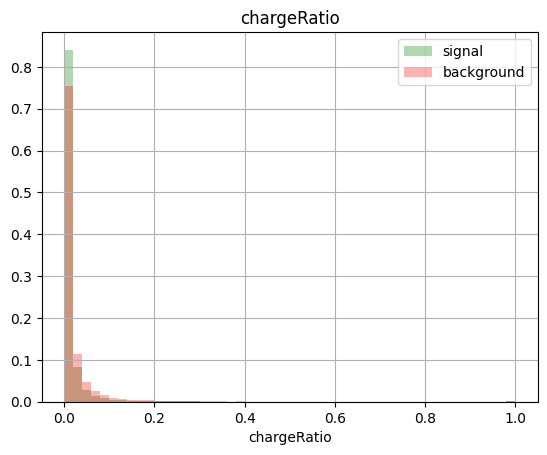

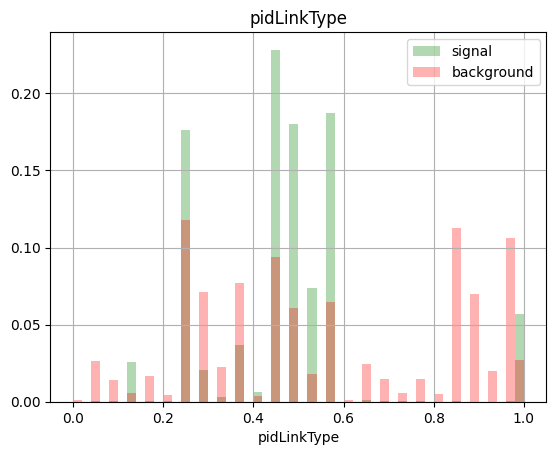

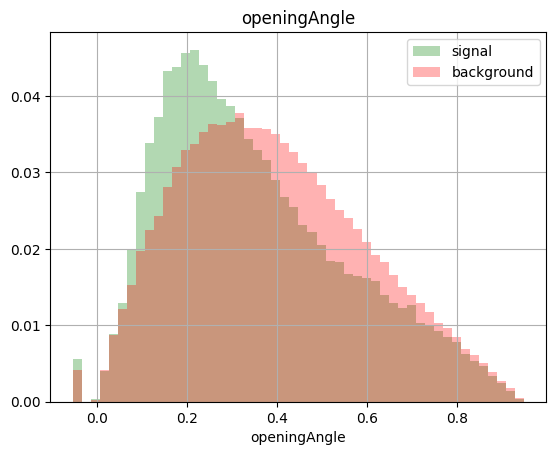

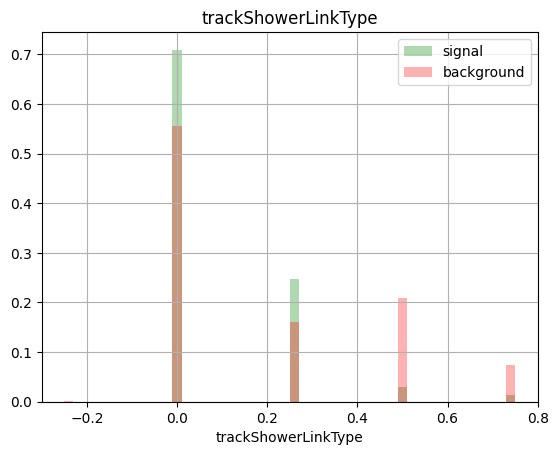

In [5]:
###########################################################
# Plot variables
###########################################################

def drawSignalBackground(variable, truth_labels, graph_label) :
    
    signal_mask_vis = (y_train == 1).reshape(-1)
    background_mask_vis = (y_train == 0).reshape(-1)

    variable_signal = variable[signal_mask_vis]
    variable_background = variable[background_mask_vis]
        
        
    signal_weights = 1.0 / float(variable_signal.shape[0])
    signal_weights = np.ones(variable_signal.shape[0]) * signal_weights

    background_weights = 1.0 / float(variable_background.shape[0])
    background_weights = np.ones(variable_background.shape[0]) * background_weights   
        
        
    plt.hist(variable_signal, bins=50, alpha=0.3, color='green', weights=signal_weights, label='signal')
    plt.hist(variable_background, bins=50, alpha=0.3, color='red', weights=background_weights, label='background')
    plt.title(graph_label)
    plt.xlabel(graph_label)
    plt.legend()
    plt.grid(True)
    plt.show()   

    
##############
drawSignalBackground(variables_train[:,0], y_train, "parentTrackScore")
drawSignalBackground(variables_train[:,1], y_train, "parentNuVertexSeparation")
drawSignalBackground(variables_train[:,2], y_train, "childNuVertexSeparation")
drawSignalBackground(variables_train[:,3], y_train, "parentEndRegionNHits")
drawSignalBackground(variables_train[:,4], y_train, "parentEndRegionNHits")
drawSignalBackground(variables_train[:,5], y_train, "parentEndRegionRToWall")
drawSignalBackground(variables_train[:,6], y_train, "vertexSeparation")
drawSignalBackground(variables_train[:,7], y_train, "separation3D")
drawSignalBackground(variables_train[:,8], y_train, "chargeRatio")
drawSignalBackground(variables_train[:,9], y_train, "pidLinkType")
drawSignalBackground(variables_train[:,10], y_train, "openingAngle")
drawSignalBackground(variables_train[:,11], y_train, "trackShowerLinkType")

In [6]:
###########################################################
# Normalise variables
###########################################################

###########
# Train
###########
# Pull out of container
parentTrackScore_norm_train = np.array(variables_train[:,0])
parentNuVertexSeparation_norm_train = np.array(variables_train[:,1])
childNuVertexSeparation_norm_train = np.array(variables_train[:,2])
parentEndRegionNHits_norm_train = np.array(variables_train[:,3])
parentEndRegionNParticles_norm_train = np.array(variables_train[:,4])
parentEndRegionRToWall_norm_train = np.array(variables_train[:,5])
vertexSeparation_norm_train = np.array(variables_train[:,6])
separation3D_norm_train = np.array(variables_train[:,7])
chargeRatio_norm_train = np.array(variables_train[:,8])
pidLinkType_norm_train = np.array(variables_train[:,9])
openingAngle_norm_train =  np.array(variables_train[:,10])
trackShowerLinkType_norm_train = np.array(variables_train[:,11])

# Normalise
normaliseXAxis(parentTrackScore_norm_train, parentTrackScore_min, parentTrackScore_max)
normaliseXAxis(parentNuVertexSeparation_norm_train, parentNuVertexSeparation_min, parentNuVertexSeparation_max)
normaliseXAxis(childNuVertexSeparation_norm_train, childNuVertexSeparation_min, childNuVertexSeparation_max)
normaliseXAxis(parentEndRegionNHits_norm_train, parentEndRegionNHits_min, parentEndRegionNHits_max)
normaliseXAxis(parentEndRegionNParticles_norm_train, parentEndRegionNParticles_min, parentEndRegionNParticles_max)
normaliseXAxis(parentEndRegionRToWall_norm_train, parentEndRegionRToWall_min, parentEndRegionRToWall_max)
normaliseXAxis(vertexSeparation_norm_train, vertexSeparation_min, vertexSeparation_max)
normaliseXAxis(separation3D_norm_train, separation3D_min, separation3D_max)
normaliseXAxis(chargeRatio_norm_train, chargeRatio_min, chargeRatio_max)
normaliseXAxis(pidLinkType_norm_train, pidLinkType_min, pidLinkType_max)
normaliseXAxis(openingAngle_norm_train, openingAngle_min, openingAngle_max)
normaliseXAxis(trackShowerLinkType_norm_train, trackShowerLinkType_min, trackShowerLinkType_max)

# Reshape
parentTrackScore_norm_train = parentTrackScore_norm_train.reshape(-1,1)
parentNuVertexSeparation_norm_train = parentNuVertexSeparation_norm_train.reshape(-1,1)
childNuVertexSeparation_norm_train = childNuVertexSeparation_norm_train.reshape(-1,1)
parentEndRegionNHits_norm_train = parentEndRegionNHits_norm_train.reshape(-1,1)
parentEndRegionNParticles_norm_train = parentEndRegionNParticles_norm_train.reshape(-1,1)
parentEndRegionRToWall_norm_train = parentEndRegionRToWall_norm_train.reshape(-1,1)
vertexSeparation_norm_train = vertexSeparation_norm_train.reshape(-1,1)
separation3D_norm_train = separation3D_norm_train.reshape(-1,1)
chargeRatio_norm_train = chargeRatio_norm_train.reshape(-1,1)
pidLinkType_norm_train = pidLinkType_norm_train.reshape(-1,1)
openingAngle_norm_train = openingAngle_norm_train.reshape(-1,1)
trackShowerLinkType_norm_train = trackShowerLinkType_norm_train.reshape(-1,1)

# Combine
variables_train = np.concatenate((parentTrackScore_norm_train, parentNuVertexSeparation_norm_train, childNuVertexSeparation_norm_train, parentEndRegionNHits_norm_train, \
                                  parentEndRegionNParticles_norm_train, parentEndRegionRToWall_norm_train, vertexSeparation_norm_train, separation3D_norm_train, chargeRatio_norm_train, \
                                  pidLinkType_norm_train, openingAngle_norm_train, trackShowerLinkType_norm_train), axis=1)

###########
# Test
###########
# Pull out of container
parentTrackScore_norm_test = np.array(variables_test[:,0])
parentNuVertexSeparation_norm_test = np.array(variables_test[:,1])
childNuVertexSeparation_norm_test = np.array(variables_test[:,2])
parentEndRegionNHits_norm_test = np.array(variables_test[:,3])
parentEndRegionNParticles_norm_test = np.array(variables_test[:,4])
parentEndRegionRToWall_norm_test = np.array(variables_test[:,5])
vertexSeparation_norm_test = np.array(variables_test[:,6])
separation3D_norm_test = np.array(variables_test[:,7])
chargeRatio_norm_test = np.array(variables_test[:,8])
pidLinkType_norm_test = np.array(variables_test[:,9])
openingAngle_norm_test =  np.array(variables_test[:,10])
trackShowerLinkType_norm_test = np.array(variables_test[:,11])

# Normalise
normaliseXAxis(parentTrackScore_norm_test, parentTrackScore_min, parentTrackScore_max)
normaliseXAxis(parentNuVertexSeparation_norm_test, parentNuVertexSeparation_min, parentNuVertexSeparation_max)
normaliseXAxis(childNuVertexSeparation_norm_test, childNuVertexSeparation_min, childNuVertexSeparation_max)
normaliseXAxis(parentEndRegionNHits_norm_test, parentEndRegionNHits_min, parentEndRegionNHits_max)
normaliseXAxis(parentEndRegionNParticles_norm_test, parentEndRegionNParticles_min, parentEndRegionNParticles_max)
normaliseXAxis(parentEndRegionRToWall_norm_test, parentEndRegionRToWall_min, parentEndRegionRToWall_max)
normaliseXAxis(vertexSeparation_norm_test, vertexSeparation_min, vertexSeparation_max)
normaliseXAxis(separation3D_norm_test, separation3D_min, separation3D_max)
normaliseXAxis(chargeRatio_norm_test, chargeRatio_min, chargeRatio_max)
normaliseXAxis(pidLinkType_norm_test, pidLinkType_min, pidLinkType_max)
normaliseXAxis(openingAngle_norm_test, openingAngle_min, openingAngle_max)
normaliseXAxis(trackShowerLinkType_norm_test, trackShowerLinkType_min, trackShowerLinkType_max)

# Reshape
parentTrackScore_norm_test = parentTrackScore_norm_test.reshape(-1,1)
parentNuVertexSeparation_norm_test = parentNuVertexSeparation_norm_test.reshape(-1,1)
childNuVertexSeparation_norm_test = childNuVertexSeparation_norm_test.reshape(-1,1)
parentEndRegionNHits_norm_test = parentEndRegionNHits_norm_test.reshape(-1,1)
parentEndRegionNParticles_norm_test = parentEndRegionNParticles_norm_test.reshape(-1,1)
parentEndRegionRToWall_norm_test = parentEndRegionRToWall_norm_test.reshape(-1,1)
vertexSeparation_norm_test = vertexSeparation_norm_test.reshape(-1,1)
separation3D_norm_test = separation3D_norm_test.reshape(-1,1)
chargeRatio_norm_test = chargeRatio_norm_test.reshape(-1,1)
pidLinkType_norm_test = pidLinkType_norm_test.reshape(-1,1)
openingAngle_norm_test = openingAngle_norm_test.reshape(-1,1)
trackShowerLinkType_norm_test = trackShowerLinkType_norm_test.reshape(-1,1)

# Combine
variables_test = np.concatenate((parentTrackScore_norm_test, parentNuVertexSeparation_norm_test, childNuVertexSeparation_norm_test, parentEndRegionNHits_norm_test, \
                                 parentEndRegionNParticles_norm_test, parentEndRegionRToWall_norm_test, vertexSeparation_norm_test, separation3D_norm_test, chargeRatio_norm_test, \
                                 pidLinkType_norm_test, openingAngle_norm_test, trackShowerLinkType_norm_test), axis=1)

In [7]:
###########################################################
# Define model
###########################################################

model = HigherTierModel.HigherTierModel(nVariables)

In [8]:
###########################################################
# Class weights?
###########################################################

nFalse = np.count_nonzero(y_train == 0)    
nTrue = np.count_nonzero(y_train == 1)  

# Normalise to largest
maxLinks = max(nFalse, nTrue)

classWeights = {0: maxLinks/nFalse, 1: maxLinks/nTrue}

print('classWeights:', classWeights)

classWeights: {0: 1.0, 1: 8.866459720203597}


In [9]:
###########################################################
# Define the optimiser and compile the model
###########################################################

optimiser = optimizers.legacy.Adam(learning_rate=learningRate)
model.compile(loss='binary_crossentropy', optimizer=optimiser, metrics=['accuracy'])

In [10]:
###########################################################
# Fit the model
###########################################################


filePath = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/other_simple_model'
    
# checkpoint
checkpoint = ModelCheckpoint(filePath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Reduce the learning rate by a factor of ten when required
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=1)

callbacks_list = [checkpoint, reduce_lr]

# Train!
history = model.fit(variables_train, y_train, validation_data=(variables_test, y_test), batch_size=batchSize, shuffle=True, epochs=nEpochs, class_weight=classWeights, callbacks=callbacks_list)

Epoch 1/10
25748/25776 [============================>.] - ETA: 0s - loss: 0.6237 - accuracy: 0.8574
Epoch 1: val_accuracy improved from -inf to 0.86252, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/other_simple_model
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/other_simple_model/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/other_simple_model/assets


25776/25776 [==============================] - 19s 713us/step - loss: 0.6237 - accuracy: 0.8574 - val_loss: 0.2988 - val_accuracy: 0.8625 - lr: 0.0010
Epoch 2/10
25750/25776 [============================>.] - ETA: 0s - loss: 0.5759 - accuracy: 0.8664
Epoch 2: val_accuracy improved from 0.86252 to 0.86360, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/other_simple_model
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/other_simple_model/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/other_simple_model/assets


25776/25776 [==============================] - 18s 681us/step - loss: 0.5759 - accuracy: 0.8664 - val_loss: 0.2962 - val_accuracy: 0.8636 - lr: 0.0010
Epoch 3/10
25703/25776 [============================>.] - ETA: 0s - loss: 0.5660 - accuracy: 0.8669
Epoch 3: val_accuracy improved from 0.86360 to 0.89018, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/other_simple_model
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/other_simple_model/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/other_simple_model/assets


25776/25776 [==============================] - 17s 670us/step - loss: 0.5658 - accuracy: 0.8669 - val_loss: 0.2538 - val_accuracy: 0.8902 - lr: 0.0010
Epoch 4/10
25756/25776 [============================>.] - ETA: 0s - loss: 0.5576 - accuracy: 0.8691
Epoch 4: val_accuracy did not improve from 0.89018
25776/25776 [==============================] - 17s 659us/step - loss: 0.5576 - accuracy: 0.8691 - val_loss: 0.2807 - val_accuracy: 0.8789 - lr: 0.0010
Epoch 5/10
25712/25776 [============================>.] - ETA: 0s - loss: 0.5513 - accuracy: 0.8707
Epoch 5: val_accuracy did not improve from 0.89018

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
25776/25776 [==============================] - 17s 666us/step - loss: 0.5514 - accuracy: 0.8707 - val_loss: 0.2648 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 6/10
25706/25776 [============================>.] - ETA: 0s - loss: 0.5334 - accuracy: 0.8755
Epoch 6: val_accuracy did not improve from 0.89018
25776/25776 [===

INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/other_simple_model/assets


25776/25776 [==============================] - 17s 665us/step - loss: 0.5286 - accuracy: 0.8759 - val_loss: 0.2508 - val_accuracy: 0.8906 - lr: 1.0000e-04
Epoch 8/10
25727/25776 [============================>.] - ETA: 0s - loss: 0.5278 - accuracy: 0.8759
Epoch 8: val_accuracy did not improve from 0.89065
25776/25776 [==============================] - 17s 664us/step - loss: 0.5278 - accuracy: 0.8759 - val_loss: 0.2562 - val_accuracy: 0.8863 - lr: 1.0000e-04
Epoch 9/10
25734/25776 [============================>.] - ETA: 0s - loss: 0.5255 - accuracy: 0.8757
Epoch 9: val_accuracy did not improve from 0.89065

Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
25776/25776 [==============================] - 17s 660us/step - loss: 0.5256 - accuracy: 0.8757 - val_loss: 0.2519 - val_accuracy: 0.8880 - lr: 1.0000e-04
Epoch 10/10
25748/25776 [============================>.] - ETA: 0s - loss: 0.5247 - accuracy: 0.8757
Epoch 10: val_accuracy did not improve from 0.89065
25

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


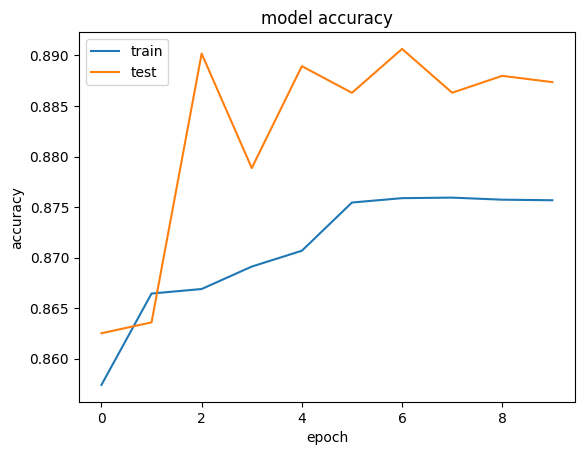

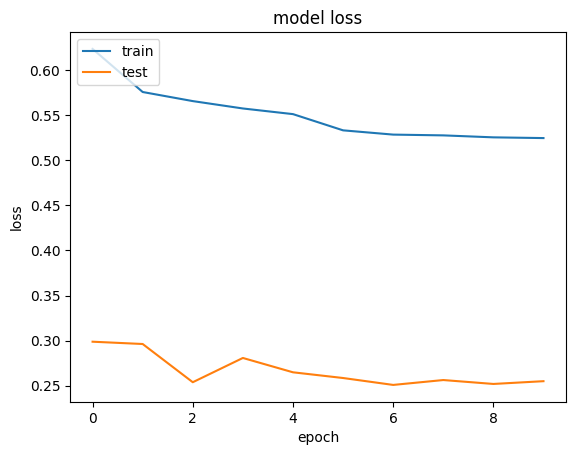

In [11]:
###########################################################
# Evaluate training
###########################################################

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
###########################################################
# Evaluate the test sample
###########################################################

y_pred = model.predict(variables_test)


5728/5728 [==============================] - 1s 240us/step


In [13]:
#######################################
# Some functions to evaluate performance
#######################################

def calculate_accuracy(scores, true_labels):
    
    scores = scores.reshape(-1)
    true_labels = true_labels.reshape(-1)
    
    true_edge_mask = (true_labels == 1)
    false_edge_mask = (true_labels == 0)
    
    true_edge_scores = scores[true_edge_mask]
    false_edge_scores = scores[false_edge_mask]
    
    thresholds = np.arange(0.05, 1.0, 0.05)
    predictions = []
    accuracy = []
    efficiency = []
    metric = []
    purity = []

    for threshold in thresholds:
        prediction = np.array(scores >= threshold, dtype='float')
        true_edge_prediction_count = np.count_nonzero(true_edge_scores >= threshold)
        false_edge_prediction_count = np.count_nonzero(false_edge_scores >= threshold)
        
        this_efficiency = float(true_edge_prediction_count) / float(true_edge_scores.shape[0])
        this_purity = float(true_edge_prediction_count) / float(true_edge_prediction_count + false_edge_prediction_count) 
        
        accuracy.append(accuracy_score(true_labels, prediction))
        efficiency.append(this_efficiency)
        purity.append(this_purity)
        metric.append(this_efficiency * this_purity)

    accuracy = np.array(accuracy)
    efficiency = np.array(efficiency)
    purity = np.array(purity)
    metric = np.array(metric)
    
    plt.clf()
    plt.scatter(thresholds, accuracy, color='blue', label='accuracy', s=10)
    plt.plot(thresholds, accuracy, color='blue')
    plt.scatter(thresholds, efficiency, color='red', label='efficiency', s=10)
    plt.plot(thresholds, efficiency, color='red')
    plt.scatter(thresholds, purity, color='green', label='purity', s=10)
    plt.plot(thresholds, purity, color='green')
    plt.scatter(thresholds, metric, color='violet', label='efficiency*purity', s=10)
    plt.plot(thresholds, metric, color='violet')
    
    plt.xlabel('threshold')
    plt.ylabel('arbitary units')
    plt.legend()
    plt.show()
        
    max_accuracy = np.max(accuracy)
    max_accuracy_index = np.argmax(accuracy)
    optimal_threshold_accuracy = thresholds[max_accuracy_index].item()

    max_metric = np.max(metric)
    max_metric_index = np.argmax(metric)
    optimal_threshold_metric = thresholds[max_metric_index].item()    
    
    return optimal_threshold_accuracy, max_accuracy, optimal_threshold_metric, max_metric

def plot_scores(scores, true_labels):
    
    true_edge_mask = (true_labels == 1).reshape(-1)
    false_edge_mask = (true_labels == 0).reshape(-1)
    
    true_edge_scores = scores[true_edge_mask]
    false_edge_scores = scores[false_edge_mask]
    
    pos_plotting_weights = 1.0 / float(true_edge_scores.shape[0])
    pos_plotting_weights = np.ones(true_edge_scores.shape[0]) * pos_plotting_weights
    neg_plotting_weights = 1.0 / float(false_edge_scores.shape[0])
    neg_plotting_weights = np.ones(false_edge_scores.shape[0]) * neg_plotting_weights
    
    plt.figure()
    plt.hist(true_edge_scores, bins=50, range=(0, 1.1), alpha=0.3, color='blue', edgecolor='black', label='true_edge_scores', weights=pos_plotting_weights)
    plt.hist(false_edge_scores, bins=50, range=(0, 1.1), alpha=0.3, color='red', edgecolor='black', label='false_edge_scores', weights=neg_plotting_weights)

    #plt.yscale('log')
    #plt.title(train_or_test)
    plt.legend()
    plt.show()    
    
    
def draw_confusion(scores, true_labels):
    
    # Need to redefine things to get them in the correct format for confusion matrix viewing
    nClasses = 2
    
    redefined_true_labels = to_categorical(true_labels, nClasses) # [false, true]
    trueProb = scores # prob that true
    falseProb = 1 - scores # prob that false
    redefined_scores = np.concatenate((falseProb, trueProb), axis=1)

    # Building the confusion matrix
    
    print(redefined_true_labels.argmax(axis=1))
    
    confMatrix = confusion_matrix(redefined_true_labels.argmax(axis=1), redefined_scores.argmax(axis=1))

    trueSums = np.sum(confMatrix, axis=1)
    predSums = np.sum(confMatrix, axis=0)

    trueNormalised = np.zeros(shape=(nClasses, nClasses))
    predNormalised = np.zeros(shape=(nClasses, nClasses))

    for trueIndex in range(nClasses) : 
        for predIndex in range(nClasses) :
            nEntries = confMatrix[trueIndex][predIndex]
            if trueSums[trueIndex] > 0 :
                trueNormalised[trueIndex][predIndex] = float(nEntries) / float(trueSums[trueIndex])
            if predSums[predIndex] > 0 :
                predNormalised[trueIndex][predIndex] = float(nEntries) / float(predSums[predIndex])

    displayTrueNorm = ConfusionMatrixDisplay(confusion_matrix=trueNormalised, display_labels=["False", "True"])
    displayTrueNorm.plot()

    displayPredNorm = ConfusionMatrixDisplay(confusion_matrix=predNormalised, display_labels=["False", "True"])
    displayPredNorm.plot()

    #print('In numbers... \n')
    #print('------------')
    #print(confMatrix)
    #print('------------')
    #print('\n As visual...')
    
    
def draw_confusion_with_threshold(scores, true_labels, threshold):
    
    # Need to redefine things to get them in the correct format for confusion matrix viewing
    nClasses = 2
    
    redefined_true_labels = true_labels.reshape(-1)
    redefined_scores = scores.reshape(-1)
    
    predicted_true_mask = redefined_scores > threshold
    predicted_false_mask = np.logical_not(predicted_true_mask)
    redefined_scores[predicted_true_mask] = 1
    redefined_scores[predicted_false_mask] = 0

    # Building the confusion matrix
    confMatrix = confusion_matrix(redefined_true_labels, redefined_scores)

    trueSums = np.sum(confMatrix, axis=1)
    predSums = np.sum(confMatrix, axis=0)

    trueNormalised = np.zeros(shape=(nClasses, nClasses))
    predNormalised = np.zeros(shape=(nClasses, nClasses))

    for trueIndex in range(nClasses) : 
        for predIndex in range(nClasses) :
            nEntries = confMatrix[trueIndex][predIndex]
            if trueSums[trueIndex] > 0 :
                trueNormalised[trueIndex][predIndex] = float(nEntries) / float(trueSums[trueIndex])
            if predSums[predIndex] > 0 :
                predNormalised[trueIndex][predIndex] = float(nEntries) / float(predSums[predIndex])

    displayTrueNorm = ConfusionMatrixDisplay(confusion_matrix=trueNormalised, display_labels=["False", "True"])
    displayTrueNorm.plot()

    displayPredNorm = ConfusionMatrixDisplay(confusion_matrix=predNormalised, display_labels=["False", "True"])
    displayPredNorm.plot()

    #print('In numbers... \n')
    #print('------------')
    #print(confMatrix)
    #print('------------')
    #print('\n As visual...')

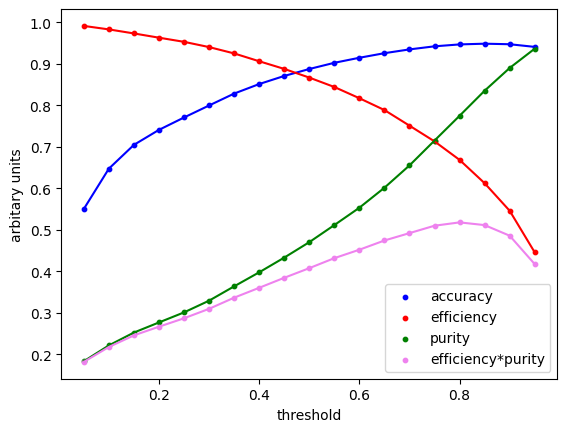

optimal_threshold: 0.8500000000000001
max_accuracy: 0.9484038867580706
optimal_threshold_metric: 0.8
max_metric: 0.5176530139796758


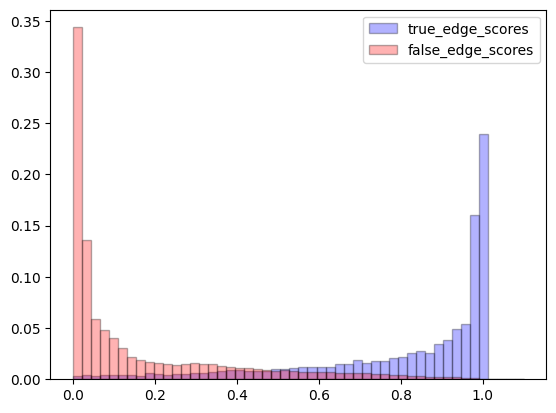

[0 0 0 ... 0 0 0]


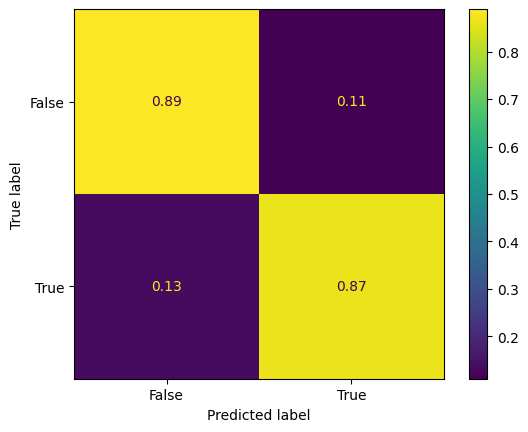

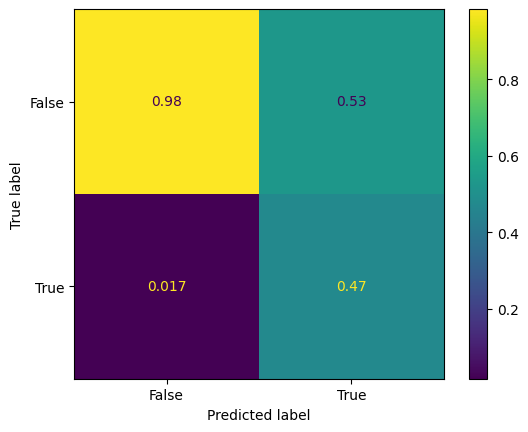

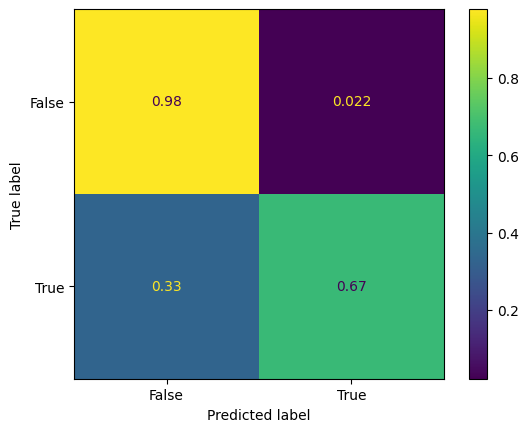

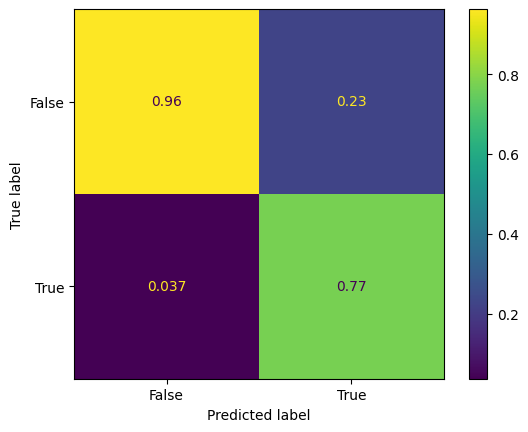

In [14]:
#######################################
# Run those functions!
#######################################

optimal_threshold, max_accuracy, optimal_threshold_metric, max_metric = calculate_accuracy(y_pred, y_test)

print('optimal_threshold:', optimal_threshold)
print('max_accuracy:', max_accuracy)
print('optimal_threshold_metric:', optimal_threshold_metric)
print('max_metric:', max_metric)

plot_scores(y_pred, y_test)
draw_confusion(y_pred, y_test)
draw_confusion_with_threshold(y_pred, y_test, optimal_threshold_metric)
